# Model details
***Used base model***: xlnet-base-cased
***Used dataset***: SQuAD
***Batch size***: 4
***Early stopping patience***: 2
***Early stopping monitor***: val loss
***Datasets***: Train: original 80k train samples, Val: remaining 7599 samples, Test: original 10570 samples
***Max length***: 384 tokens
***Loss function***: Sparse categorical crossentropy
***Attempted train epochs***: 4
***Initial learning rate***: 2e-5
***End learning rate***: 0
***Additional info***: Filtered out samples with number of tokens exceeding 384, stride mechanism isn't used
***Status***: NOT TRAINED YET

In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
)
import tensorflow as tf
from question_answering.constants import constants
from question_answering.utils import core_qa_utils
from question_answering.utils.extractive_qa import (
    graphs,
    model_management,
    predictions,
    squad_metrics,
    pure_metrics,
    core_preprocessing,
    squad_preprocessing,
    medical_preprocessing,
)
from question_answering.paths import extractive_qa_paths
import ipynbname
from question_answering.keras_callbacks.time_measure_callback import TimeMeasureCallback
import numpy as np
from datasets import Dataset

# Data loading

In [2]:
raw_train_dataset, raw_test_dataset = core_qa_utils.load_datasets_from_json(
    dataset_path=extractive_qa_paths.squad_dataset_dir,
    filenames=["original_train.json", "original_test.json"],
)

In [3]:
train_dataset = raw_train_dataset.select(range(80000))
val_dataset = raw_train_dataset.select(range(80000, 87599))
test_dataset = raw_test_dataset

In [4]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 80000
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 7599
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', 'answer_text', 'answer_start'],
     num_rows: 10570
 }))

# Data preprocessing

In [5]:
model_checkpoint = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Filter out samples exceeding 384 tokens

In [6]:
max_length = 384

In [7]:
filtered_train_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=train_dataset, max_tokens=max_length
)
filtered_val_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=val_dataset, max_tokens=max_length
)
filtered_test_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=test_dataset, max_tokens=max_length
)

In [8]:
print(f"Train | BEFORE: {len(train_dataset)} | AFTER: {len(filtered_train_dataset)}")
print(f"Val | BEFORE: {len(val_dataset)} | AFTER: {len(filtered_val_dataset)}")
print(f"Test | BEFORE: {len(test_dataset)} | AFTER: {len(filtered_test_dataset)}")

Train | BEFORE: 80000 | AFTER: 78916
Val | BEFORE: 7599 | AFTER: 7502
Test | BEFORE: 10570 | AFTER: 10332


In [9]:
tokenized_train_dataset = squad_preprocessing.preprocess_squad_training_dataset_no_stride(
    dataset=filtered_train_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=train_dataset.column_names,
)
tokenized_val_dataset = squad_preprocessing.preprocess_squad_training_dataset_no_stride(
    dataset=filtered_val_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=val_dataset.column_names,
)

Map:   0%|          | 0/7502 [00:00<?, ? examples/s]

In [10]:
tokenized_test_dataset = squad_preprocessing.preprocess_squad_test_dataset_no_stride(
    dataset=filtered_test_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=test_dataset.column_names,
)

# Training preparation

In [11]:
# Model parameters
full_model_name = "-".join(ipynbname.name().split("_"))

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
        extractive_qa_paths.training_checkpoints_dir
        / full_model_name
        / checkpoint_filename_template
)

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Evaluation
model_evaluation_dir = extractive_qa_paths.model_evaluation_dir / full_model_name
figures_dir = model_evaluation_dir / constants.figures_dir_name

# Hyper parameters
batch_size = 4
train_epochs = 4
initial_learning_rate = 2e-5
end_learning_rate = 0

In [12]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)
tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=None,
    collator=data_collator,
    batch_size=batch_size,
)

In [13]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForQuestionAnsweringSimple: ['lm_loss']
- This IS expected if you are initializing TFXLNetForQuestionAnsweringSimple from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForQuestionAnsweringSimple from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceCla

In [14]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=2)
time_measure_cb = TimeMeasureCallback()

callbacks = [checkpoint_cb, early_stop_cb, time_measure_cb]

In [15]:
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=end_learning_rate,
    decay_steps=num_train_steps,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
qa_metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=qa_metrics)

In [16]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


# Model training

In [17]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/4
19729/19729 [==============================] - ETA: 0s - loss: 2.1570 - end_logits_loss: 1.0254 - start_logits_loss: 1.1316 - end_logits_accuracy: 0.7073 - start_logits_accuracy: 0.6683
Epoch 1: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-xlnet-cased-no-stride-1\cp-01.ckpt
19729/19729 [==============================] - 5573s 282ms/step - loss: 2.1570 - end_logits_loss: 1.0254 - start_logits_loss: 1.1316 - end_logits_accuracy: 0.7073 - start_logits_accuracy: 0.6683 - val_loss: 1.7837 - val_end_logits_loss: 0.8307 - val_start_logits_loss: 0.9529 - val_end_logits_accuracy: 0.7523 - val_start_logits_accuracy: 0.7050
Epoch 2/4
19729/19729 [==============================] - ETA: 0s - loss: 1.3798 - end_logits_loss: 0.6459 - start_logits_loss: 0.7339 - end_logits_accuracy: 0.8011 - start_logits_accuracy: 0.7647
Epoch 2: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-xlnet-cased-no-stride-1\c

In [18]:
history = history.history

In [19]:
core_qa_utils.save_dict_as_json(
    dictionary=history, dir_path=model_evaluation_dir, filename="history.json"
)

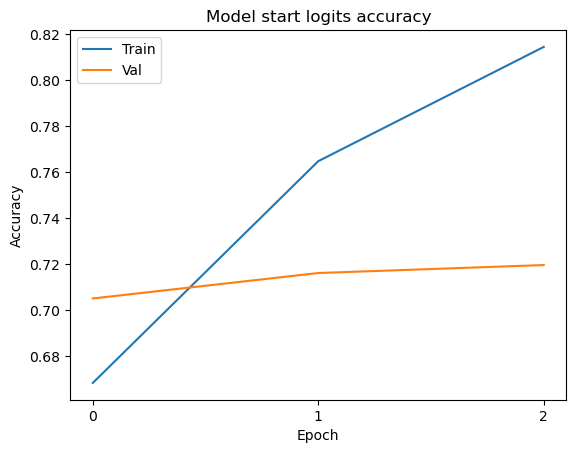

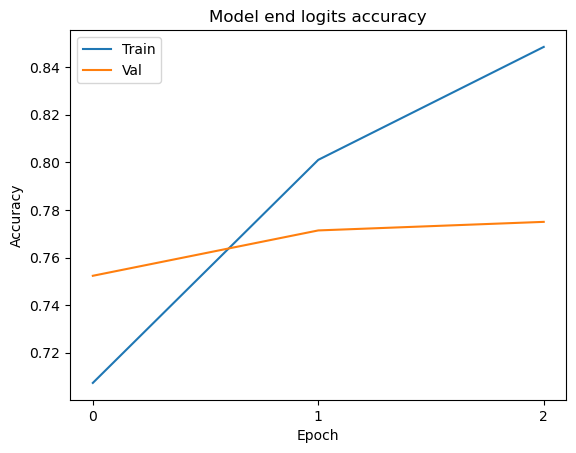

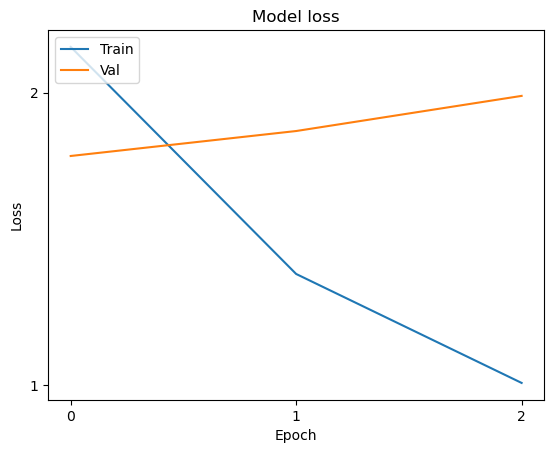

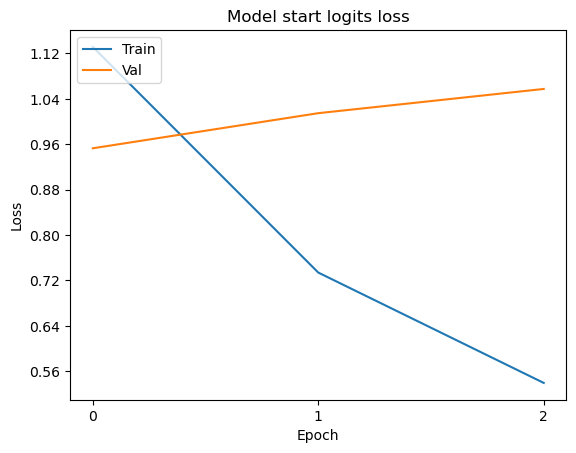

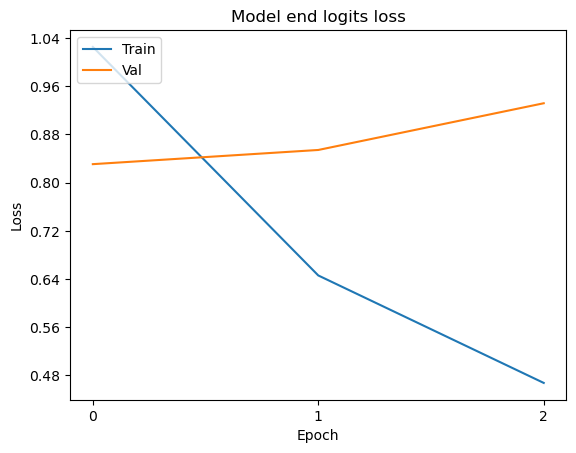

In [20]:
# Plot training figures
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"start_accuracy.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"end_accuracy.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"loss.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"start_loss.png",
)
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"end_loss.png",
)

# Saving model's best version & training data

In [21]:
history = core_qa_utils.read_json_as_dict(model_evaluation_dir / "history.json")

In [22]:
best_epoch = core_qa_utils.get_best_epoch(
    history=history, metric="val_loss", metric_evaluator="min"
)

In [23]:
training_data = {
    "history": history,
    "attempted_epochs": train_epochs,
    "best_epoch": best_epoch,
    "training_time": time_measure_cb.total_training_time(),
    "gpu": core_qa_utils.get_gpu_name(),
}

In [24]:
core_qa_utils.save_dict_as_json(
    training_data, dir_path=model_evaluation_dir, filename="training_data.json"
)

In [25]:
best_model = model_management.load_best_model_from_checkpoints(
    model=model, model_name=full_model_name, epoch=best_epoch, remove_checkpoints=True
)

In [26]:
model_management.save_model(model=best_model, model_name=full_model_name)

# Getting predictions

In [17]:
loaded_model = model_management.load_model(
    model_checkpoint=model_checkpoint, model_name=full_model_name
)
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=qa_metrics)

InvalidArgumentError: Exception encountered when calling layer "rel_attn" "                 f"(type TFXLNetRelativeAttention).

cannot compute Einsum as input #1(zero-based) was expected to be a float tensor but is a half tensor [Op:Einsum]

Call arguments received by layer "rel_attn" "                 f"(type TFXLNetRelativeAttention):
  • h=tf.Tensor(shape=(2, 1, 768), dtype=float16)
  • g=None
  • attn_mask_h=tf.Tensor(shape=(2, 2, 1, 1), dtype=float32)
  • attn_mask_g=tf.Tensor(shape=(1, 2, 1, 1), dtype=float32)
  • r=tf.Tensor(shape=(4, 1, 768), dtype=float16)
  • seg_mat=tf.Tensor(shape=(2, 2, 1, 2), dtype=float32)
  • mems=None
  • target_mapping=None
  • head_mask=None
  • output_attentions=False
  • training=False

In [29]:
output = loaded_model.predict(tf_test_dataset)

  68/2583 [..............................] - ETA: 3:34

ResourceExhaustedError: Graph execution error:

Detected at node 'tfxl_net_for_question_answering_simple/transformer/layer_._1/rel_attn/einsum_5/Einsum' defined at (most recent call last):
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell
      result = self._run_cell(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell
      result = runner(coro)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Karol\AppData\Local\Temp\ipykernel_9060\3207124399.py", line 1, in <module>
      output = loaded_model.predict(tf_test_dataset)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\modeling_tf_utils.py", line 1640, in run_call_with_unpacked_inputs
      y_pred = self(x, training=True)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 1659, in call
      transformer_outputs = self.transformer(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\modeling_tf_utils.py", line 1640, in run_call_with_unpacked_inputs
      y_pred = self(x, training=True)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 734, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 741, in call
      outputs = layer_module(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 380, in call
      outputs = self.rel_attn(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 206, in call
      if g is not None:
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 307, in call
      attn_vec = self.rel_attn_core(
    File "C:\Users\Karol\miniconda3\envs\question_answering\lib\site-packages\transformers\models\xlnet\modeling_tf_xlnet.py", line 143, in rel_attn_core
      bd = tf.einsum("ibnd,jbnd->ijbn", q_head + self.r_r_bias, k_head_r)
Node: 'tfxl_net_for_question_answering_simple/transformer/layer_._1/rel_attn/einsum_5/Einsum'
OOM when allocating tensor with shape[384,768,4,12] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node tfxl_net_for_question_answering_simple/transformer/layer_._1/rel_attn/einsum_5/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1531493]

In [ ]:
# Get predictions
output_start_logits = predictions.get_preds(
    output, output_key="start_logits", return_type="logits"
)
output_end_logits = predictions.get_preds(
    output, output_key="end_logits", return_type="logits"
)

output_start_positions = predictions.get_preds(
    output, output_key="start_logits", return_type="class"
)
output_end_positions = predictions.get_preds(
    output, output_key="end_logits", return_type="class"
)

In [ ]:
def get_predicted_texts_for_multiple_n_best(
        start_logits: np.ndarray,
        end_logits: np.ndarray,
        features: Dataset,
        examples: Dataset,
        n_best_variants: list[int],
):
    predicted_texts_for_varying_n_best = []
    for n_best_variant in n_best_variants:
        predicted_texts = predictions.get_predicted_texts(
            start_logits=start_logits,
            end_logits=end_logits,
            features=features,
            examples=examples,
            n_best=n_best_variant,
        )
        predicted_texts_for_varying_n_best.append(predicted_texts)

    return predicted_texts_for_varying_n_best

In [ ]:
n_bests = ["01", "02", "03", "05", "10", "20"]

textual_predictions_variants = get_predicted_texts_for_multiple_n_best(
    start_logits=output_start_logits,
    end_logits=output_end_logits,
    features=tokenized_test_dataset,
    examples=test_dataset,
    n_best_variants=[int(n_best) for n_best in n_bests],
)

# Metrics & evaluation

### Accuracies

In [ ]:
accuracies_metrics = squad_metrics.calculate_squad_accuracies(
    start_actual=tokenized_test_dataset["start_positions"],
    end_actual=tokenized_test_dataset["end_positions"],
    start_preds=output_start_positions,
    end_preds=output_end_positions,
)
accuracies_metrics

### Precision, recall, F1-score, exact match

In [ ]:
def calculate_all_variants_of_squad_qa_metrics(
        answers: list[list[str]],
        predicted_texts_variants: list[list[str]],
):
    metrics = []
    for predicted_texts_variant in predicted_texts_variants:
        non_normalized_metrics = squad_metrics.calculate_squad_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=False
        )
        normalized_metrics = squad_metrics.calculate_squad_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=True
        )
        metrics.append(non_normalized_metrics)
        metrics.append(normalized_metrics)

    return metrics

In [ ]:
qa_metrics = calculate_all_variants_of_squad_qa_metrics(
    answers=test_dataset["answer_text"],
    predicted_texts_variants=textual_predictions_variants,
)

### Correct predictions by sentence lengths

In [ ]:
best_textual_predictions = textual_predictions_variants[2]
correctly_predicted = squad_metrics.get_is_correctly_predicted(
    answers=test_dataset["answer_text"],
    predicted_texts=best_textual_predictions,
    normalize=True,
)

In [ ]:
# Plot correctness of the model by sentence length
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_300_50.png",
    figure_title="Correctness by sentence length",
    divider=50,
    min_threshold=0,
    max_threshold=300,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_320_80.png",
    figure_title="Correctness by sentence length",
    divider=80,
    min_threshold=0,
    max_threshold=320,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_0_400_100.png",
    figure_title="Correctness by sentence length",
    divider=100,
    min_threshold=0,
    max_threshold=300,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=test_dataset["context"],
    correctly_predicted=correctly_predicted,
    figure_path=figures_dir / "context_correctness_by_sentence_length_30_180_30.png",
    figure_title="Correctness by sentence length",
    divider=30,
    min_threshold=30,
    max_threshold=180,
)

### Saving evaluation data

In [ ]:
evaluation_data = {
    "accuracy": accuracies_metrics,
    "precision": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": qa_metrics[
            i
        ]["precision"]
        for i in range(len(n_bests) * 2)
    },
    "recall": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": qa_metrics[
            i
        ]["recall"]
        for i in range(len(n_bests) * 2)
    },
    "f1": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": qa_metrics[
            i
        ]["f1"]
        for i in range(len(n_bests) * 2)
    },
    "exact_match": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": qa_metrics[
            i
        ]["exact_match"]
        for i in range(len(n_bests) * 2)
    },
}

In [ ]:
core_qa_utils.save_dict_as_json(
    evaluation_data, dir_path=model_evaluation_dir, filename="evaluation_data.json"
)

# Medical dataset evaluation

In [ ]:
raw_medical_dataset = core_qa_utils.load_datasets_from_json(
    dataset_path=extractive_qa_paths.medical_dataset_dir,
    filenames=["original_medical.json"],
)[0]

In [ ]:
window_size = 550

In [30]:
spanned_medical_dataset = medical_preprocessing.span_dataset(
    dataset=raw_medical_dataset,
    window=window_size,
)

NameError: name 'raw_medical_dataset' is not defined

In [31]:
filtered_medical_dataset = core_preprocessing.filter_samples_below_number_of_tokens(
    tokenizer=tokenizer, dataset=spanned_medical_dataset, max_tokens=max_length
)

NameError: name 'spanned_medical_dataset' is not defined

In [ ]:
print(f"Medical | BEFORE: {len(spanned_medical_dataset)} | AFTER: {len(filtered_medical_dataset)}")

In [ ]:
tokenized_medical_dataset = medical_preprocessing.preprocess_medical_test_dataset_no_stride(
    dataset=filtered_medical_dataset,
    tokenizer=tokenizer,
    max_length=max_length,
    remove_columns=spanned_medical_dataset.column_names,
)

In [ ]:
tf_medical_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_medical_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=None,
    collator=data_collator,
    batch_size=batch_size,
)

### Getting predictions

In [ ]:
medical_output = loaded_model.predict(tf_medical_dataset)

In [ ]:
# Get predictions
medical_output_start_logits = predictions.get_preds(
    medical_output, output_key="start_logits", return_type="logits"
)
medical_output_end_logits = predictions.get_preds(
    medical_output, output_key="end_logits", return_type="logits"
)

medical_output_start_positions = predictions.get_preds(
    medical_output, output_key="start_logits", return_type="class"
)
medical_output_end_positions = predictions.get_preds(
    medical_output, output_key="end_logits", return_type="class"
)

In [ ]:
n_bests = ["01", "02", "03", "05", "10", "20"]

medical_textual_predictions_variants = get_predicted_texts_for_multiple_n_best(
    start_logits=medical_output_start_logits,
    end_logits=medical_output_end_logits,
    features=tokenized_medical_dataset,
    examples=spanned_medical_dataset,
    n_best_variants=[int(n_best) for n_best in n_bests],
)

# Metrics & evaluation of medical dataset

### Accuracies

In [ ]:
medical_accuracies_metrics = pure_metrics.calculate_pure_accuracies(
    start_actual=tokenized_medical_dataset["start_positions"],
    end_actual=tokenized_medical_dataset["end_positions"],
    start_preds=medical_output_start_positions,
    end_preds=medical_output_end_positions,
)
medical_accuracies_metrics

### Precision, recall, F1-score, exact match

In [ ]:
def calculate_all_variants_of_pure_qa_metrics(
        answers: list[str],
        predicted_texts_variants: list[list[str]],
):
    metrics = []
    for predicted_texts_variant in predicted_texts_variants:
        non_normalized_metrics = pure_metrics.calculate_pure_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=False
        )
        normalized_metrics = pure_metrics.calculate_pure_qa_metrics(
            answers=answers, predicted_texts=predicted_texts_variant, normalize=True
        )
        metrics.append(non_normalized_metrics)
        metrics.append(normalized_metrics)

    return metrics

In [ ]:
valid_answers = [sample["answer_text"][0] for sample in spanned_medical_dataset]
medical_qa_metrics = calculate_all_variants_of_pure_qa_metrics(
    answers=valid_answers,
    predicted_texts_variants=medical_textual_predictions_variants,
)

### Correct predictions by sentence lengths

In [ ]:
medical_best_textual_predictions = medical_textual_predictions_variants[4]
medical_correctly_predicted = pure_metrics.get_is_correctly_predicted(
    answers=valid_answers,
    predicted_texts=medical_best_textual_predictions,
    normalize=True,
)

In [ ]:
# Plot correctness of the model by sentence length
graphs.plot_correct_predictions_by_sentence_length(
    sentences=spanned_medical_dataset["context"],
    correctly_predicted=medical_correctly_predicted,
    figure_path=figures_dir
                / "medical_context_correctness_by_sentence_length_0_200_40.png",
    figure_title="Correctness by sentence length",
    divider=40,
    min_threshold=0,
    max_threshold=200,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=spanned_medical_dataset["context"],
    correctly_predicted=medical_correctly_predicted,
    figure_path=figures_dir
                / "medical_context_correctness_by_sentence_length_60_240_60.png",
    figure_title="Correctness by sentence length",
    divider=60,
    min_threshold=60,
    max_threshold=240,
)
graphs.plot_correct_predictions_by_sentence_length(
    sentences=spanned_medical_dataset["context"],
    correctly_predicted=medical_correctly_predicted,
    figure_path=figures_dir
                / "medical_context_correctness_by_sentence_length_100_200_20.png",
    figure_title="Correctness by sentence length",
    divider=20,
    min_threshold=100,
    max_threshold=200,
)

### Saving evaluation data

In [ ]:
medical_evaluation_data = {
    "accuracy": medical_accuracies_metrics,
    "precision": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": medical_qa_metrics[
            i
        ][
            "precision"
        ]
        for i in range(len(n_bests) * 2)
    },
    "recall": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": medical_qa_metrics[
            i
        ][
            "recall"
        ]
        for i in range(len(n_bests) * 2)
    },
    "f1": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": medical_qa_metrics[
            i
        ][
            "f1"
        ]
        for i in range(len(n_bests) * 2)
    },
    "exact_match": {
        f"{n_bests[i // 2]}_best_{'normalized' if i % 2 else 'standard'}": medical_qa_metrics[
            i
        ][
            "exact_match"
        ]
        for i in range(len(n_bests) * 2)
    },
}

In [ ]:
core_qa_utils.save_dict_as_json(
    medical_evaluation_data,
    dir_path=model_evaluation_dir,
    filename="medical_evaluation_data.json",
)

# Saving complete results

In [ ]:
training_data = core_qa_utils.read_json_as_dict(
    model_evaluation_dir / "training_data.json"
)

In [ ]:
evaluation_data = core_qa_utils.read_json_as_dict(
    model_evaluation_dir / "evaluation_data.json"
)

In [ ]:
medical_evaluation_data = core_qa_utils.read_json_as_dict(
    model_evaluation_dir / "medical_evaluation_data.json"
)

In [ ]:
complete_evaluation_data = {
    "training": training_data,
    "evaluation": evaluation_data,
    "medical_evaluation": medical_evaluation_data,
}

In [ ]:
core_qa_utils.save_dict_as_json(
    complete_evaluation_data,
    dir_path=model_evaluation_dir,
    filename="complete_evaluation_data.json",
)